# One-vs-All Kernel Perceptron with Polynomial Kernels

In [2]:
import numpy as np
from tqdm import tqdm
from tabulate import tabulate
import matplotlib.pyplot as plt

In [3]:
class MultiClassPerceptronOVA:
    def __init__(self, train_data, train_labels, test_data, test_labels, kernel_type, kernel_param, epochs):
        """
        Initialize the One-vs-All Kernel Perceptron.

        Inputs:
        - train_data (ndarray): Training data features.
        - train_labels (ndarray): Labels corresponding to training data.
        - test_data (ndarray): Test data features.
        - test_labels (ndarray): Labels corresponding to test data.
        - kernel_type(str): Type of kernel ('p' for polynomial, 'g' for Gaussian).
        - kernel_param(float): Parameter for the kernel (degree for polynomial, c for Gaussian).
        - epochs (int): Number of training epochs.

        """
        self.train_data = train_data
        self.train_labels = train_labels
        self.test_data = test_data
        self.test_labels = test_labels
        self.epochs = epochs
        self.classes = np.unique(np.hstack((train_labels, test_labels)))
        self.num_classes = len(self.classes)
        
        self.train_count = train_labels.size
        self.test_count = test_labels.size
        self.kernel_type = kernel_type
        self.kernel_param = kernel_param
        self.kernel_train = self.kernel_compute(train_data, train_data, kernel_type, kernel_param)
        self.kernel_test = self.kernel_compute(test_data, train_data, kernel_type, kernel_param)
        self.alpha = np.zeros((self.num_classes, self.train_count))
        
    def kernel_compute(self, A, B, k_type, k_arg):
        """
        Compute the kernel matrix.

        Inputs:
        - A (ndarray): First data matrix.
        - B (ndarray): Second data matrix.
        - k_type (str): Type of kernel ('p' for polynomial, 'g' for Gaussian).
        - k_arg (float): Parameter for the kernel (degree for polynomial, c for Gaussian).

        Output:
        - ndarray: Computed kernel matrix.
        """
        if k_type == 'p':
            return (A @ B.T) ** k_arg
        if k_type == 'g':
            squared_dist = np.sum(A**2, axis=1)[:, None] + np.sum(B**2, axis=1) - 2 * (A @ B.T)
            return np.exp(-k_arg * squared_dist)

    def train(self):
        """
        Train the model using the One-vs-All strategy.

        Output:
        - float: Training error rate after the final epoch.
        """
        for _ in range(self.epochs):
            misclassifications = 0
            for idx in range(self.train_count):
                for label_idx, label in enumerate(self.classes):
                    binary_label = 1 if self.train_labels[idx] == label else -1
                    prediction = np.sum(self.alpha[label_idx] * self.kernel_train[:, idx])
                    if np.sign(prediction) != binary_label:
                        self.alpha[label_idx, idx] += binary_label
                        misclassifications += 1
            print(f"Epoch complete. Misclassifications: {misclassifications}")
        return np.mean(self.predict(self.train_data, True) != self.train_labels)

    def predict(self, data, training_phase):
        """
        Predict class labels for given data.

        Inputs:
        - data (ndarray): Data points to classify.
        - training_phase (bool): Whether the prediction is for training (True) or testing (False).

        Output:
        - ndarray: Predicted class labels.
        """
        kernel_matrix = self.kernel_train if training_phase else self.kernel_test
        class_scores = np.zeros((data.shape[0], self.num_classes))
        for class_idx in range(self.num_classes):
            class_scores[:, class_idx] = self.alpha[class_idx] @ kernel_matrix.T
        return self.classes[np.argmax(class_scores, axis=1)]

    def test(self):
        """
        Evaluate the OvA Kernel Perceptron on the test set.

        Output:
        - float: Test error rate.
        """
        return np.mean(self.predict(self.test_data, False) != self.test_labels)


In [4]:
# Helper function to split data
def train_test_split(X, y, train_ratio=0.8, shuffle=True, random_seed=None):
    """
    Split dataset into training and testing sets.

    Inputs:
    - X (ndarray): Feature data.
    - y (ndarray): Corresponding labels.
    - train_ratio (float): Proportion of data for training (default is 0.8).
    - shuffle (bool): Whether to shuffle data before splitting (default is True).
    - random_seed (int or None): Random seed for reproducibility (default is None).

    Outputs:
    - Tuple[ndarray, ndarray, ndarray, ndarray]: 
      Training features, test features, training labels, test labels.
    """
    if shuffle:
        np.random.seed(random_seed)
        indices = np.arange(len(X))
        np.random.shuffle(indices)
        X, y = X[indices], y[indices]
    n_train = int(train_ratio * len(X))
    return X[:n_train], X[n_train:], y[:n_train], y[n_train:]

In [5]:
# Load dataset
X, y = np.loadtxt("zipcombo.dat")[:, 1:], np.loadtxt("zipcombo.dat")[:, 0].astype(int)

In [6]:
# Initialize settings
np.random.seed(42)
train_ratio = 0.8
degree_range = np.arange(1, 8) # Polynomial degree range for kernel testing
training_errors, testing_errors, training_stddevs, testing_stddevs = [], [], [], []

# Iterate over different polynomial degrees for the kernel
for degree in degree_range:
    print(f"Processing polynomial degree {degree}...")
    train_errs, test_errs = [], []  # Temporary lists to store errors for each run

    # Perform 20 independent runs for each polynomial degree
    for run_id in tqdm(range(20), desc=f"Degree {degree}"):
        # Split dataset into training and testing sets with a consistent seed
        train_X, test_X, train_y, test_y = train_test_split(
            X, y, train_ratio=train_ratio, random_seed=run_id
        )
        
        # Initialize and train the multi-class perceptron with the current polynomial kernel degree
        model = MultiClassPerceptronOVA(
            train_X, train_y, test_X, test_y, 
            kernel_type='p', kernel_param=degree, epochs=5
        )
        model.train()  # Train the model for the specified number of epochs

        # Predict outcomes on training and testing data
        train_preds = model.predict(train_X, training_phase=True)
        test_preds = model.predict(test_X, training_phase=False)

        # Calculate and store the error rates for this run
        train_errs.append(np.mean(train_preds != train_y))
        test_errs.append(np.mean(test_preds != test_y))

    # Compute and store mean and standard deviation of errors across 20 runs
    training_errors.append(np.mean(train_errs))
    training_stddevs.append(np.std(train_errs))
    testing_errors.append(np.mean(test_errs))
    testing_stddevs.append(np.std(test_errs))

    # Output results for the current degree
    print(f"Degree {degree}: Train Error = {training_errors[-1]:.4f}, Test Error = {testing_errors[-1]:.4f}")

Processing polynomial degree 1...


Degree 1:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch complete. Misclassifications: 2778
Epoch complete. Misclassifications: 2006
Epoch complete. Misclassifications: 1834
Epoch complete. Misclassifications: 1718
Epoch complete. Misclassifications: 1637


Degree 1:   5%|▌         | 1/20 [00:32<10:19, 32.60s/it]

Epoch complete. Misclassifications: 2811
Epoch complete. Misclassifications: 2007
Epoch complete. Misclassifications: 1831
Epoch complete. Misclassifications: 1760
Epoch complete. Misclassifications: 1681


Degree 1:  10%|█         | 2/20 [01:06<10:02, 33.50s/it]

Epoch complete. Misclassifications: 2803
Epoch complete. Misclassifications: 2041
Epoch complete. Misclassifications: 1875
Epoch complete. Misclassifications: 1754
Epoch complete. Misclassifications: 1716


Degree 1:  15%|█▌        | 3/20 [01:41<09:37, 33.99s/it]

Epoch complete. Misclassifications: 2804
Epoch complete. Misclassifications: 1933
Epoch complete. Misclassifications: 1795
Epoch complete. Misclassifications: 1722
Epoch complete. Misclassifications: 1614


Degree 1:  20%|██        | 4/20 [02:14<08:57, 33.60s/it]

Epoch complete. Misclassifications: 2852
Epoch complete. Misclassifications: 2078
Epoch complete. Misclassifications: 1862
Epoch complete. Misclassifications: 1810
Epoch complete. Misclassifications: 1732


Degree 1:  25%|██▌       | 5/20 [02:44<08:07, 32.48s/it]

Epoch complete. Misclassifications: 2748
Epoch complete. Misclassifications: 1988
Epoch complete. Misclassifications: 1842
Epoch complete. Misclassifications: 1776
Epoch complete. Misclassifications: 1653


Degree 1:  30%|███       | 6/20 [03:16<07:29, 32.11s/it]

Epoch complete. Misclassifications: 2772
Epoch complete. Misclassifications: 1992
Epoch complete. Misclassifications: 1815
Epoch complete. Misclassifications: 1712
Epoch complete. Misclassifications: 1656


Degree 1:  35%|███▌      | 7/20 [03:47<06:54, 31.91s/it]

Epoch complete. Misclassifications: 2850
Epoch complete. Misclassifications: 1995
Epoch complete. Misclassifications: 1842
Epoch complete. Misclassifications: 1785
Epoch complete. Misclassifications: 1649


Degree 1:  40%|████      | 8/20 [04:19<06:22, 31.85s/it]

Epoch complete. Misclassifications: 2831
Epoch complete. Misclassifications: 2047
Epoch complete. Misclassifications: 1856
Epoch complete. Misclassifications: 1735
Epoch complete. Misclassifications: 1759


Degree 1:  45%|████▌     | 9/20 [04:50<05:48, 31.71s/it]

Epoch complete. Misclassifications: 2816
Epoch complete. Misclassifications: 1999
Epoch complete. Misclassifications: 1814
Epoch complete. Misclassifications: 1764
Epoch complete. Misclassifications: 1705


Degree 1:  50%|█████     | 10/20 [05:21<05:14, 31.46s/it]

Epoch complete. Misclassifications: 2828
Epoch complete. Misclassifications: 2036
Epoch complete. Misclassifications: 1849
Epoch complete. Misclassifications: 1787
Epoch complete. Misclassifications: 1685


Degree 1:  55%|█████▌    | 11/20 [05:53<04:44, 31.58s/it]

Epoch complete. Misclassifications: 2823
Epoch complete. Misclassifications: 2009
Epoch complete. Misclassifications: 1780
Epoch complete. Misclassifications: 1770
Epoch complete. Misclassifications: 1670


Degree 1:  60%|██████    | 12/20 [06:25<04:14, 31.81s/it]

Epoch complete. Misclassifications: 2772
Epoch complete. Misclassifications: 1982
Epoch complete. Misclassifications: 1875
Epoch complete. Misclassifications: 1773
Epoch complete. Misclassifications: 1726


Degree 1:  65%|██████▌   | 13/20 [06:57<03:43, 31.88s/it]

Epoch complete. Misclassifications: 2763
Epoch complete. Misclassifications: 1998
Epoch complete. Misclassifications: 1821
Epoch complete. Misclassifications: 1755
Epoch complete. Misclassifications: 1638


Degree 1:  70%|███████   | 14/20 [07:28<03:09, 31.51s/it]

Epoch complete. Misclassifications: 2777
Epoch complete. Misclassifications: 1965
Epoch complete. Misclassifications: 1819
Epoch complete. Misclassifications: 1731
Epoch complete. Misclassifications: 1660


Degree 1:  75%|███████▌  | 15/20 [07:59<02:37, 31.44s/it]

Epoch complete. Misclassifications: 2841
Epoch complete. Misclassifications: 2055
Epoch complete. Misclassifications: 1829
Epoch complete. Misclassifications: 1731
Epoch complete. Misclassifications: 1699


Degree 1:  80%|████████  | 16/20 [08:32<02:06, 31.64s/it]

Epoch complete. Misclassifications: 2718
Epoch complete. Misclassifications: 1943
Epoch complete. Misclassifications: 1834
Epoch complete. Misclassifications: 1713
Epoch complete. Misclassifications: 1647


Degree 1:  85%|████████▌ | 17/20 [09:03<01:34, 31.52s/it]

Epoch complete. Misclassifications: 2782
Epoch complete. Misclassifications: 2022
Epoch complete. Misclassifications: 1806
Epoch complete. Misclassifications: 1763
Epoch complete. Misclassifications: 1635


Degree 1:  90%|█████████ | 18/20 [09:33<01:02, 31.07s/it]

Epoch complete. Misclassifications: 2856
Epoch complete. Misclassifications: 2054
Epoch complete. Misclassifications: 1850
Epoch complete. Misclassifications: 1731
Epoch complete. Misclassifications: 1664


Degree 1:  95%|█████████▌| 19/20 [10:04<00:31, 31.13s/it]

Epoch complete. Misclassifications: 2810
Epoch complete. Misclassifications: 1951
Epoch complete. Misclassifications: 1764
Epoch complete. Misclassifications: 1712
Epoch complete. Misclassifications: 1656


Degree 1: 100%|██████████| 20/20 [10:35<00:00, 31.78s/it]


Degree 1: Train Error = 0.0786, Test Error = 0.0989
Processing polynomial degree 2...


Degree 2:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch complete. Misclassifications: 1780
Epoch complete. Misclassifications: 795
Epoch complete. Misclassifications: 548
Epoch complete. Misclassifications: 425
Epoch complete. Misclassifications: 315


Degree 2:   5%|▌         | 1/20 [00:30<09:31, 30.06s/it]

Epoch complete. Misclassifications: 1862
Epoch complete. Misclassifications: 792
Epoch complete. Misclassifications: 551
Epoch complete. Misclassifications: 405
Epoch complete. Misclassifications: 311


Degree 2:  10%|█         | 2/20 [01:00<09:07, 30.42s/it]

Epoch complete. Misclassifications: 1866
Epoch complete. Misclassifications: 843
Epoch complete. Misclassifications: 556
Epoch complete. Misclassifications: 407
Epoch complete. Misclassifications: 305


Degree 2:  15%|█▌        | 3/20 [01:31<08:38, 30.48s/it]

Epoch complete. Misclassifications: 1763
Epoch complete. Misclassifications: 773
Epoch complete. Misclassifications: 503
Epoch complete. Misclassifications: 441
Epoch complete. Misclassifications: 343


Degree 2:  20%|██        | 4/20 [02:02<08:09, 30.58s/it]

Epoch complete. Misclassifications: 1859
Epoch complete. Misclassifications: 820
Epoch complete. Misclassifications: 534
Epoch complete. Misclassifications: 428
Epoch complete. Misclassifications: 328


Degree 2:  25%|██▌       | 5/20 [02:32<07:39, 30.61s/it]

Epoch complete. Misclassifications: 1885
Epoch complete. Misclassifications: 818
Epoch complete. Misclassifications: 522
Epoch complete. Misclassifications: 410
Epoch complete. Misclassifications: 340


Degree 2:  30%|███       | 6/20 [03:04<07:12, 30.92s/it]

Epoch complete. Misclassifications: 1810
Epoch complete. Misclassifications: 777
Epoch complete. Misclassifications: 498
Epoch complete. Misclassifications: 387
Epoch complete. Misclassifications: 289


Degree 2:  35%|███▌      | 7/20 [03:35<06:42, 30.96s/it]

Epoch complete. Misclassifications: 1863
Epoch complete. Misclassifications: 796
Epoch complete. Misclassifications: 567
Epoch complete. Misclassifications: 392
Epoch complete. Misclassifications: 317


Degree 2:  40%|████      | 8/20 [04:06<06:13, 31.11s/it]

Epoch complete. Misclassifications: 1838
Epoch complete. Misclassifications: 813
Epoch complete. Misclassifications: 516
Epoch complete. Misclassifications: 385
Epoch complete. Misclassifications: 326


Degree 2:  45%|████▌     | 9/20 [04:37<05:40, 30.95s/it]

Epoch complete. Misclassifications: 1826
Epoch complete. Misclassifications: 769
Epoch complete. Misclassifications: 568
Epoch complete. Misclassifications: 426
Epoch complete. Misclassifications: 314


Degree 2:  50%|█████     | 10/20 [05:08<05:10, 31.09s/it]

Epoch complete. Misclassifications: 1839
Epoch complete. Misclassifications: 811
Epoch complete. Misclassifications: 508
Epoch complete. Misclassifications: 373
Epoch complete. Misclassifications: 291


Degree 2:  55%|█████▌    | 11/20 [05:39<04:38, 30.91s/it]

Epoch complete. Misclassifications: 1811
Epoch complete. Misclassifications: 779
Epoch complete. Misclassifications: 503
Epoch complete. Misclassifications: 373
Epoch complete. Misclassifications: 290


Degree 2:  60%|██████    | 12/20 [06:10<04:08, 31.02s/it]

Epoch complete. Misclassifications: 1893
Epoch complete. Misclassifications: 797
Epoch complete. Misclassifications: 527
Epoch complete. Misclassifications: 413
Epoch complete. Misclassifications: 320


Degree 2:  65%|██████▌   | 13/20 [06:40<03:35, 30.82s/it]

Epoch complete. Misclassifications: 1804
Epoch complete. Misclassifications: 744
Epoch complete. Misclassifications: 507
Epoch complete. Misclassifications: 400
Epoch complete. Misclassifications: 305


Degree 2:  70%|███████   | 14/20 [07:09<03:01, 30.24s/it]

Epoch complete. Misclassifications: 1799
Epoch complete. Misclassifications: 799
Epoch complete. Misclassifications: 553
Epoch complete. Misclassifications: 379
Epoch complete. Misclassifications: 297


Degree 2:  75%|███████▌  | 15/20 [07:39<02:30, 30.06s/it]

Epoch complete. Misclassifications: 1868
Epoch complete. Misclassifications: 797
Epoch complete. Misclassifications: 503
Epoch complete. Misclassifications: 384
Epoch complete. Misclassifications: 308


Degree 2:  80%|████████  | 16/20 [08:10<02:01, 30.36s/it]

Epoch complete. Misclassifications: 1795
Epoch complete. Misclassifications: 790
Epoch complete. Misclassifications: 488
Epoch complete. Misclassifications: 360
Epoch complete. Misclassifications: 347


Degree 2:  85%|████████▌ | 17/20 [08:41<01:31, 30.53s/it]

Epoch complete. Misclassifications: 1825
Epoch complete. Misclassifications: 827
Epoch complete. Misclassifications: 473
Epoch complete. Misclassifications: 365
Epoch complete. Misclassifications: 296


Degree 2:  90%|█████████ | 18/20 [09:12<01:01, 30.57s/it]

Epoch complete. Misclassifications: 1819
Epoch complete. Misclassifications: 775
Epoch complete. Misclassifications: 528
Epoch complete. Misclassifications: 426
Epoch complete. Misclassifications: 343


Degree 2:  95%|█████████▌| 19/20 [09:42<00:30, 30.64s/it]

Epoch complete. Misclassifications: 1790
Epoch complete. Misclassifications: 755
Epoch complete. Misclassifications: 515
Epoch complete. Misclassifications: 407
Epoch complete. Misclassifications: 295


Degree 2: 100%|██████████| 20/20 [10:14<00:00, 30.71s/it]


Degree 2: Train Error = 0.0073, Test Error = 0.0373
Processing polynomial degree 3...


Degree 3:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch complete. Misclassifications: 1570
Epoch complete. Misclassifications: 505
Epoch complete. Misclassifications: 284
Epoch complete. Misclassifications: 199
Epoch complete. Misclassifications: 152


Degree 3:   5%|▌         | 1/20 [00:33<10:36, 33.48s/it]

Epoch complete. Misclassifications: 1578
Epoch complete. Misclassifications: 503
Epoch complete. Misclassifications: 309
Epoch complete. Misclassifications: 196
Epoch complete. Misclassifications: 117


Degree 3:  10%|█         | 2/20 [01:06<10:02, 33.50s/it]

Epoch complete. Misclassifications: 1600
Epoch complete. Misclassifications: 509
Epoch complete. Misclassifications: 263
Epoch complete. Misclassifications: 228
Epoch complete. Misclassifications: 131


Degree 3:  15%|█▌        | 3/20 [01:40<09:31, 33.59s/it]

Epoch complete. Misclassifications: 1574
Epoch complete. Misclassifications: 463
Epoch complete. Misclassifications: 273
Epoch complete. Misclassifications: 208
Epoch complete. Misclassifications: 153


Degree 3:  20%|██        | 4/20 [02:14<09:00, 33.79s/it]

Epoch complete. Misclassifications: 1574
Epoch complete. Misclassifications: 476
Epoch complete. Misclassifications: 289
Epoch complete. Misclassifications: 215
Epoch complete. Misclassifications: 145


Degree 3:  25%|██▌       | 5/20 [02:49<08:33, 34.20s/it]

Epoch complete. Misclassifications: 1603
Epoch complete. Misclassifications: 494
Epoch complete. Misclassifications: 285
Epoch complete. Misclassifications: 202
Epoch complete. Misclassifications: 138


Degree 3:  30%|███       | 6/20 [03:24<08:03, 34.53s/it]

Epoch complete. Misclassifications: 1545
Epoch complete. Misclassifications: 485
Epoch complete. Misclassifications: 286
Epoch complete. Misclassifications: 191
Epoch complete. Misclassifications: 119


Degree 3:  35%|███▌      | 7/20 [03:58<07:25, 34.27s/it]

Epoch complete. Misclassifications: 1630
Epoch complete. Misclassifications: 538
Epoch complete. Misclassifications: 303
Epoch complete. Misclassifications: 172
Epoch complete. Misclassifications: 130


Degree 3:  40%|████      | 8/20 [04:31<06:47, 33.93s/it]

Epoch complete. Misclassifications: 1578
Epoch complete. Misclassifications: 553
Epoch complete. Misclassifications: 273
Epoch complete. Misclassifications: 207
Epoch complete. Misclassifications: 147


Degree 3:  45%|████▌     | 9/20 [05:05<06:11, 33.77s/it]

Epoch complete. Misclassifications: 1614
Epoch complete. Misclassifications: 486
Epoch complete. Misclassifications: 255
Epoch complete. Misclassifications: 193
Epoch complete. Misclassifications: 141


Degree 3:  50%|█████     | 10/20 [05:38<05:36, 33.67s/it]

Epoch complete. Misclassifications: 1552
Epoch complete. Misclassifications: 512
Epoch complete. Misclassifications: 289
Epoch complete. Misclassifications: 164
Epoch complete. Misclassifications: 133


Degree 3:  55%|█████▌    | 11/20 [06:12<05:02, 33.56s/it]

Epoch complete. Misclassifications: 1529
Epoch complete. Misclassifications: 520
Epoch complete. Misclassifications: 255
Epoch complete. Misclassifications: 186
Epoch complete. Misclassifications: 119


Degree 3:  60%|██████    | 12/20 [06:45<04:27, 33.41s/it]

Epoch complete. Misclassifications: 1571
Epoch complete. Misclassifications: 506
Epoch complete. Misclassifications: 298
Epoch complete. Misclassifications: 184
Epoch complete. Misclassifications: 139


Degree 3:  65%|██████▌   | 13/20 [07:18<03:54, 33.49s/it]

Epoch complete. Misclassifications: 1531
Epoch complete. Misclassifications: 507
Epoch complete. Misclassifications: 231
Epoch complete. Misclassifications: 199
Epoch complete. Misclassifications: 137


Degree 3:  70%|███████   | 14/20 [07:52<03:21, 33.53s/it]

Epoch complete. Misclassifications: 1583
Epoch complete. Misclassifications: 533
Epoch complete. Misclassifications: 300
Epoch complete. Misclassifications: 164
Epoch complete. Misclassifications: 152


Degree 3:  75%|███████▌  | 15/20 [08:26<02:48, 33.68s/it]

Epoch complete. Misclassifications: 1592
Epoch complete. Misclassifications: 522
Epoch complete. Misclassifications: 286
Epoch complete. Misclassifications: 177
Epoch complete. Misclassifications: 104


Degree 3:  80%|████████  | 16/20 [09:00<02:15, 33.82s/it]

Epoch complete. Misclassifications: 1570
Epoch complete. Misclassifications: 489
Epoch complete. Misclassifications: 264
Epoch complete. Misclassifications: 179
Epoch complete. Misclassifications: 156


Degree 3:  85%|████████▌ | 17/20 [09:33<01:41, 33.70s/it]

Epoch complete. Misclassifications: 1546
Epoch complete. Misclassifications: 513
Epoch complete. Misclassifications: 270
Epoch complete. Misclassifications: 185
Epoch complete. Misclassifications: 119


Degree 3:  90%|█████████ | 18/20 [10:07<01:07, 33.58s/it]

Epoch complete. Misclassifications: 1553
Epoch complete. Misclassifications: 530
Epoch complete. Misclassifications: 301
Epoch complete. Misclassifications: 209
Epoch complete. Misclassifications: 147


Degree 3:  95%|█████████▌| 19/20 [10:40<00:33, 33.59s/it]

Epoch complete. Misclassifications: 1536
Epoch complete. Misclassifications: 489
Epoch complete. Misclassifications: 264
Epoch complete. Misclassifications: 194
Epoch complete. Misclassifications: 119


Degree 3: 100%|██████████| 20/20 [11:15<00:00, 33.78s/it]


Degree 3: Train Error = 0.0020, Test Error = 0.0304
Processing polynomial degree 4...


Degree 4:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch complete. Misclassifications: 1479
Epoch complete. Misclassifications: 401
Epoch complete. Misclassifications: 185
Epoch complete. Misclassifications: 131
Epoch complete. Misclassifications: 105


Degree 4:   5%|▌         | 1/20 [00:32<10:26, 32.96s/it]

Epoch complete. Misclassifications: 1512
Epoch complete. Misclassifications: 385
Epoch complete. Misclassifications: 204
Epoch complete. Misclassifications: 103
Epoch complete. Misclassifications: 66


Degree 4:  10%|█         | 2/20 [01:07<10:06, 33.67s/it]

Epoch complete. Misclassifications: 1477
Epoch complete. Misclassifications: 417
Epoch complete. Misclassifications: 188
Epoch complete. Misclassifications: 107
Epoch complete. Misclassifications: 64


Degree 4:  15%|█▌        | 3/20 [01:41<09:36, 33.92s/it]

Epoch complete. Misclassifications: 1444
Epoch complete. Misclassifications: 379
Epoch complete. Misclassifications: 222
Epoch complete. Misclassifications: 124
Epoch complete. Misclassifications: 101


Degree 4:  20%|██        | 4/20 [02:15<09:06, 34.15s/it]

Epoch complete. Misclassifications: 1498
Epoch complete. Misclassifications: 386
Epoch complete. Misclassifications: 185
Epoch complete. Misclassifications: 126
Epoch complete. Misclassifications: 74


Degree 4:  25%|██▌       | 5/20 [02:48<08:26, 33.77s/it]

Epoch complete. Misclassifications: 1474
Epoch complete. Misclassifications: 396
Epoch complete. Misclassifications: 201
Epoch complete. Misclassifications: 112
Epoch complete. Misclassifications: 73


Degree 4:  30%|███       | 6/20 [03:22<07:52, 33.75s/it]

Epoch complete. Misclassifications: 1456
Epoch complete. Misclassifications: 395
Epoch complete. Misclassifications: 172
Epoch complete. Misclassifications: 112
Epoch complete. Misclassifications: 68


Degree 4:  35%|███▌      | 7/20 [03:56<07:19, 33.80s/it]

Epoch complete. Misclassifications: 1450
Epoch complete. Misclassifications: 421
Epoch complete. Misclassifications: 217
Epoch complete. Misclassifications: 144
Epoch complete. Misclassifications: 81


Degree 4:  40%|████      | 8/20 [04:30<06:45, 33.82s/it]

Epoch complete. Misclassifications: 1490
Epoch complete. Misclassifications: 420
Epoch complete. Misclassifications: 191
Epoch complete. Misclassifications: 123
Epoch complete. Misclassifications: 61


Degree 4:  45%|████▌     | 9/20 [05:04<06:12, 33.86s/it]

Epoch complete. Misclassifications: 1463
Epoch complete. Misclassifications: 427
Epoch complete. Misclassifications: 177
Epoch complete. Misclassifications: 131
Epoch complete. Misclassifications: 87


Degree 4:  50%|█████     | 10/20 [05:38<05:39, 33.98s/it]

Epoch complete. Misclassifications: 1457
Epoch complete. Misclassifications: 369
Epoch complete. Misclassifications: 211
Epoch complete. Misclassifications: 138
Epoch complete. Misclassifications: 87


Degree 4:  55%|█████▌    | 11/20 [06:12<05:04, 33.80s/it]

Epoch complete. Misclassifications: 1429
Epoch complete. Misclassifications: 401
Epoch complete. Misclassifications: 170
Epoch complete. Misclassifications: 124
Epoch complete. Misclassifications: 74


Degree 4:  60%|██████    | 12/20 [06:45<04:30, 33.85s/it]

Epoch complete. Misclassifications: 1486
Epoch complete. Misclassifications: 381
Epoch complete. Misclassifications: 203
Epoch complete. Misclassifications: 147
Epoch complete. Misclassifications: 70


Degree 4:  65%|██████▌   | 13/20 [07:20<03:57, 33.94s/it]

Epoch complete. Misclassifications: 1447
Epoch complete. Misclassifications: 407
Epoch complete. Misclassifications: 196
Epoch complete. Misclassifications: 113
Epoch complete. Misclassifications: 65


Degree 4:  70%|███████   | 14/20 [07:53<03:23, 33.88s/it]

Epoch complete. Misclassifications: 1480
Epoch complete. Misclassifications: 422
Epoch complete. Misclassifications: 169
Epoch complete. Misclassifications: 99
Epoch complete. Misclassifications: 93


Degree 4:  75%|███████▌  | 15/20 [08:27<02:49, 33.95s/it]

Epoch complete. Misclassifications: 1472
Epoch complete. Misclassifications: 379
Epoch complete. Misclassifications: 193
Epoch complete. Misclassifications: 144
Epoch complete. Misclassifications: 71


Degree 4:  80%|████████  | 16/20 [09:01<02:15, 33.93s/it]

Epoch complete. Misclassifications: 1475
Epoch complete. Misclassifications: 362
Epoch complete. Misclassifications: 188
Epoch complete. Misclassifications: 103
Epoch complete. Misclassifications: 81


Degree 4:  85%|████████▌ | 17/20 [09:35<01:41, 33.81s/it]

Epoch complete. Misclassifications: 1472
Epoch complete. Misclassifications: 409
Epoch complete. Misclassifications: 182
Epoch complete. Misclassifications: 115
Epoch complete. Misclassifications: 102


Degree 4:  90%|█████████ | 18/20 [10:09<01:07, 33.76s/it]

Epoch complete. Misclassifications: 1435
Epoch complete. Misclassifications: 411
Epoch complete. Misclassifications: 205
Epoch complete. Misclassifications: 104
Epoch complete. Misclassifications: 58


Degree 4:  95%|█████████▌| 19/20 [10:42<00:33, 33.80s/it]

Epoch complete. Misclassifications: 1448
Epoch complete. Misclassifications: 382
Epoch complete. Misclassifications: 180
Epoch complete. Misclassifications: 117
Epoch complete. Misclassifications: 82


Degree 4: 100%|██████████| 20/20 [11:16<00:00, 33.81s/it]


Degree 4: Train Error = 0.0007, Test Error = 0.0282
Processing polynomial degree 5...


Degree 5:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch complete. Misclassifications: 1408
Epoch complete. Misclassifications: 342
Epoch complete. Misclassifications: 146
Epoch complete. Misclassifications: 76
Epoch complete. Misclassifications: 38


Degree 5:   5%|▌         | 1/20 [00:33<10:41, 33.77s/it]

Epoch complete. Misclassifications: 1491
Epoch complete. Misclassifications: 342
Epoch complete. Misclassifications: 155
Epoch complete. Misclassifications: 105
Epoch complete. Misclassifications: 63


Degree 5:  10%|█         | 2/20 [01:07<10:06, 33.68s/it]

Epoch complete. Misclassifications: 1439
Epoch complete. Misclassifications: 350
Epoch complete. Misclassifications: 125
Epoch complete. Misclassifications: 74
Epoch complete. Misclassifications: 32


Degree 5:  15%|█▌        | 3/20 [01:40<09:30, 33.56s/it]

Epoch complete. Misclassifications: 1425
Epoch complete. Misclassifications: 347
Epoch complete. Misclassifications: 164
Epoch complete. Misclassifications: 89
Epoch complete. Misclassifications: 60


Degree 5:  20%|██        | 4/20 [02:14<08:59, 33.71s/it]

Epoch complete. Misclassifications: 1434
Epoch complete. Misclassifications: 370
Epoch complete. Misclassifications: 177
Epoch complete. Misclassifications: 100
Epoch complete. Misclassifications: 46


Degree 5:  25%|██▌       | 5/20 [02:48<08:26, 33.75s/it]

Epoch complete. Misclassifications: 1438
Epoch complete. Misclassifications: 327
Epoch complete. Misclassifications: 167
Epoch complete. Misclassifications: 81
Epoch complete. Misclassifications: 50


Degree 5:  30%|███       | 6/20 [03:22<07:53, 33.82s/it]

Epoch complete. Misclassifications: 1416
Epoch complete. Misclassifications: 375
Epoch complete. Misclassifications: 151
Epoch complete. Misclassifications: 92
Epoch complete. Misclassifications: 54


Degree 5:  35%|███▌      | 7/20 [03:57<07:22, 34.07s/it]

Epoch complete. Misclassifications: 1474
Epoch complete. Misclassifications: 346
Epoch complete. Misclassifications: 155
Epoch complete. Misclassifications: 80
Epoch complete. Misclassifications: 55


Degree 5:  40%|████      | 8/20 [04:31<06:48, 34.03s/it]

Epoch complete. Misclassifications: 1405
Epoch complete. Misclassifications: 366
Epoch complete. Misclassifications: 160
Epoch complete. Misclassifications: 94
Epoch complete. Misclassifications: 65


Degree 5:  45%|████▌     | 9/20 [05:04<06:12, 33.91s/it]

Epoch complete. Misclassifications: 1421
Epoch complete. Misclassifications: 372
Epoch complete. Misclassifications: 165
Epoch complete. Misclassifications: 95
Epoch complete. Misclassifications: 60


Degree 5:  50%|█████     | 10/20 [05:38<05:40, 34.02s/it]

Epoch complete. Misclassifications: 1432
Epoch complete. Misclassifications: 332
Epoch complete. Misclassifications: 154
Epoch complete. Misclassifications: 97
Epoch complete. Misclassifications: 67


Degree 5:  55%|█████▌    | 11/20 [06:12<05:04, 33.88s/it]

Epoch complete. Misclassifications: 1420
Epoch complete. Misclassifications: 332
Epoch complete. Misclassifications: 123
Epoch complete. Misclassifications: 98
Epoch complete. Misclassifications: 66


Degree 5:  60%|██████    | 12/20 [06:47<04:33, 34.21s/it]

Epoch complete. Misclassifications: 1451
Epoch complete. Misclassifications: 365
Epoch complete. Misclassifications: 158
Epoch complete. Misclassifications: 79
Epoch complete. Misclassifications: 45


Degree 5:  65%|██████▌   | 13/20 [07:21<03:59, 34.21s/it]

Epoch complete. Misclassifications: 1398
Epoch complete. Misclassifications: 352
Epoch complete. Misclassifications: 167
Epoch complete. Misclassifications: 82
Epoch complete. Misclassifications: 58


Degree 5:  70%|███████   | 14/20 [07:56<03:26, 34.40s/it]

Epoch complete. Misclassifications: 1417
Epoch complete. Misclassifications: 358
Epoch complete. Misclassifications: 153
Epoch complete. Misclassifications: 102
Epoch complete. Misclassifications: 61


Degree 5:  75%|███████▌  | 15/20 [08:30<02:51, 34.38s/it]

Epoch complete. Misclassifications: 1436
Epoch complete. Misclassifications: 345
Epoch complete. Misclassifications: 144
Epoch complete. Misclassifications: 76
Epoch complete. Misclassifications: 29


Degree 5:  80%|████████  | 16/20 [09:04<02:16, 34.18s/it]

Epoch complete. Misclassifications: 1380
Epoch complete. Misclassifications: 338
Epoch complete. Misclassifications: 180
Epoch complete. Misclassifications: 83
Epoch complete. Misclassifications: 59


Degree 5:  85%|████████▌ | 17/20 [09:38<01:41, 33.99s/it]

Epoch complete. Misclassifications: 1426
Epoch complete. Misclassifications: 351
Epoch complete. Misclassifications: 161
Epoch complete. Misclassifications: 105
Epoch complete. Misclassifications: 42


Degree 5:  90%|█████████ | 18/20 [10:11<01:07, 33.93s/it]

Epoch complete. Misclassifications: 1412
Epoch complete. Misclassifications: 342
Epoch complete. Misclassifications: 179
Epoch complete. Misclassifications: 87
Epoch complete. Misclassifications: 61


Degree 5:  95%|█████████▌| 19/20 [10:44<00:33, 33.52s/it]

Epoch complete. Misclassifications: 1392
Epoch complete. Misclassifications: 332
Epoch complete. Misclassifications: 133
Epoch complete. Misclassifications: 85
Epoch complete. Misclassifications: 69


Degree 5: 100%|██████████| 20/20 [11:19<00:00, 33.95s/it]


Degree 5: Train Error = 0.0006, Test Error = 0.0283
Processing polynomial degree 6...


Degree 6:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch complete. Misclassifications: 1412
Epoch complete. Misclassifications: 320
Epoch complete. Misclassifications: 134
Epoch complete. Misclassifications: 86
Epoch complete. Misclassifications: 52


Degree 6:   5%|▌         | 1/20 [00:33<10:36, 33.50s/it]

Epoch complete. Misclassifications: 1477
Epoch complete. Misclassifications: 327
Epoch complete. Misclassifications: 128
Epoch complete. Misclassifications: 75
Epoch complete. Misclassifications: 47


Degree 6:  10%|█         | 2/20 [01:08<10:16, 34.23s/it]

Epoch complete. Misclassifications: 1429
Epoch complete. Misclassifications: 331
Epoch complete. Misclassifications: 130
Epoch complete. Misclassifications: 76
Epoch complete. Misclassifications: 31


Degree 6:  15%|█▌        | 3/20 [01:41<09:36, 33.89s/it]

Epoch complete. Misclassifications: 1403
Epoch complete. Misclassifications: 340
Epoch complete. Misclassifications: 120
Epoch complete. Misclassifications: 99
Epoch complete. Misclassifications: 59


Degree 6:  20%|██        | 4/20 [02:16<09:07, 34.21s/it]

Epoch complete. Misclassifications: 1457
Epoch complete. Misclassifications: 325
Epoch complete. Misclassifications: 141
Epoch complete. Misclassifications: 73
Epoch complete. Misclassifications: 35


Degree 6:  25%|██▌       | 5/20 [02:49<08:29, 33.97s/it]

Epoch complete. Misclassifications: 1456
Epoch complete. Misclassifications: 306
Epoch complete. Misclassifications: 129
Epoch complete. Misclassifications: 68
Epoch complete. Misclassifications: 34


Degree 6:  30%|███       | 6/20 [03:24<07:56, 34.07s/it]

Epoch complete. Misclassifications: 1435
Epoch complete. Misclassifications: 321
Epoch complete. Misclassifications: 121
Epoch complete. Misclassifications: 64
Epoch complete. Misclassifications: 38


Degree 6:  35%|███▌      | 7/20 [03:58<07:25, 34.26s/it]

Epoch complete. Misclassifications: 1457
Epoch complete. Misclassifications: 341
Epoch complete. Misclassifications: 123
Epoch complete. Misclassifications: 76
Epoch complete. Misclassifications: 43


Degree 6:  40%|████      | 8/20 [04:34<06:54, 34.56s/it]

Epoch complete. Misclassifications: 1439
Epoch complete. Misclassifications: 365
Epoch complete. Misclassifications: 137
Epoch complete. Misclassifications: 57
Epoch complete. Misclassifications: 38


Degree 6:  45%|████▌     | 9/20 [05:08<06:19, 34.46s/it]

Epoch complete. Misclassifications: 1411
Epoch complete. Misclassifications: 378
Epoch complete. Misclassifications: 150
Epoch complete. Misclassifications: 68
Epoch complete. Misclassifications: 47


Degree 6:  50%|█████     | 10/20 [05:43<05:45, 34.55s/it]

Epoch complete. Misclassifications: 1423
Epoch complete. Misclassifications: 348
Epoch complete. Misclassifications: 149
Epoch complete. Misclassifications: 74
Epoch complete. Misclassifications: 33


Degree 6:  55%|█████▌    | 11/20 [06:16<05:08, 34.33s/it]

Epoch complete. Misclassifications: 1412
Epoch complete. Misclassifications: 288
Epoch complete. Misclassifications: 137
Epoch complete. Misclassifications: 69
Epoch complete. Misclassifications: 37


Degree 6:  60%|██████    | 12/20 [06:51<04:34, 34.35s/it]

Epoch complete. Misclassifications: 1447
Epoch complete. Misclassifications: 345
Epoch complete. Misclassifications: 125
Epoch complete. Misclassifications: 59
Epoch complete. Misclassifications: 33


Degree 6:  65%|██████▌   | 13/20 [07:25<04:00, 34.32s/it]

Epoch complete. Misclassifications: 1383
Epoch complete. Misclassifications: 324
Epoch complete. Misclassifications: 134
Epoch complete. Misclassifications: 70
Epoch complete. Misclassifications: 46


Degree 6:  70%|███████   | 14/20 [07:59<03:25, 34.29s/it]

Epoch complete. Misclassifications: 1395
Epoch complete. Misclassifications: 348
Epoch complete. Misclassifications: 156
Epoch complete. Misclassifications: 85
Epoch complete. Misclassifications: 46


Degree 6:  75%|███████▌  | 15/20 [08:34<02:51, 34.35s/it]

Epoch complete. Misclassifications: 1438
Epoch complete. Misclassifications: 337
Epoch complete. Misclassifications: 115
Epoch complete. Misclassifications: 55
Epoch complete. Misclassifications: 35


Degree 6:  80%|████████  | 16/20 [09:08<02:17, 34.35s/it]

Epoch complete. Misclassifications: 1375
Epoch complete. Misclassifications: 321
Epoch complete. Misclassifications: 150
Epoch complete. Misclassifications: 70
Epoch complete. Misclassifications: 34


Degree 6:  85%|████████▌ | 17/20 [09:43<01:43, 34.48s/it]

Epoch complete. Misclassifications: 1420
Epoch complete. Misclassifications: 310
Epoch complete. Misclassifications: 141
Epoch complete. Misclassifications: 70
Epoch complete. Misclassifications: 35


Degree 6:  90%|█████████ | 18/20 [10:17<01:08, 34.40s/it]

Epoch complete. Misclassifications: 1430
Epoch complete. Misclassifications: 350
Epoch complete. Misclassifications: 124
Epoch complete. Misclassifications: 68
Epoch complete. Misclassifications: 52


Degree 6:  95%|█████████▌| 19/20 [10:52<00:34, 34.68s/it]

Epoch complete. Misclassifications: 1402
Epoch complete. Misclassifications: 318
Epoch complete. Misclassifications: 135
Epoch complete. Misclassifications: 73
Epoch complete. Misclassifications: 43


Degree 6: 100%|██████████| 20/20 [11:26<00:00, 34.34s/it]


Degree 6: Train Error = 0.0003, Test Error = 0.0273
Processing polynomial degree 7...


Degree 7:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch complete. Misclassifications: 1440
Epoch complete. Misclassifications: 315
Epoch complete. Misclassifications: 116
Epoch complete. Misclassifications: 56
Epoch complete. Misclassifications: 42


Degree 7:   5%|▌         | 1/20 [00:34<10:59, 34.71s/it]

Epoch complete. Misclassifications: 1499
Epoch complete. Misclassifications: 290
Epoch complete. Misclassifications: 120
Epoch complete. Misclassifications: 68
Epoch complete. Misclassifications: 38


Degree 7:  10%|█         | 2/20 [01:10<10:33, 35.21s/it]

Epoch complete. Misclassifications: 1457
Epoch complete. Misclassifications: 322
Epoch complete. Misclassifications: 127
Epoch complete. Misclassifications: 47
Epoch complete. Misclassifications: 33


Degree 7:  15%|█▌        | 3/20 [01:44<09:52, 34.86s/it]

Epoch complete. Misclassifications: 1439
Epoch complete. Misclassifications: 303
Epoch complete. Misclassifications: 123
Epoch complete. Misclassifications: 61
Epoch complete. Misclassifications: 26


Degree 7:  20%|██        | 4/20 [02:17<09:05, 34.10s/it]

Epoch complete. Misclassifications: 1426
Epoch complete. Misclassifications: 345
Epoch complete. Misclassifications: 145
Epoch complete. Misclassifications: 62
Epoch complete. Misclassifications: 29


Degree 7:  25%|██▌       | 5/20 [02:49<08:19, 33.30s/it]

Epoch complete. Misclassifications: 1485
Epoch complete. Misclassifications: 301
Epoch complete. Misclassifications: 119
Epoch complete. Misclassifications: 52
Epoch complete. Misclassifications: 27


Degree 7:  30%|███       | 6/20 [03:21<07:41, 32.96s/it]

Epoch complete. Misclassifications: 1420
Epoch complete. Misclassifications: 292
Epoch complete. Misclassifications: 120
Epoch complete. Misclassifications: 65
Epoch complete. Misclassifications: 45


Degree 7:  35%|███▌      | 7/20 [03:54<07:07, 32.88s/it]

Epoch complete. Misclassifications: 1487
Epoch complete. Misclassifications: 319
Epoch complete. Misclassifications: 130
Epoch complete. Misclassifications: 62
Epoch complete. Misclassifications: 30


Degree 7:  40%|████      | 8/20 [04:28<06:38, 33.25s/it]

Epoch complete. Misclassifications: 1437
Epoch complete. Misclassifications: 330
Epoch complete. Misclassifications: 125
Epoch complete. Misclassifications: 53
Epoch complete. Misclassifications: 32


Degree 7:  45%|████▌     | 9/20 [05:02<06:08, 33.50s/it]

Epoch complete. Misclassifications: 1443
Epoch complete. Misclassifications: 348
Epoch complete. Misclassifications: 118
Epoch complete. Misclassifications: 63
Epoch complete. Misclassifications: 36


Degree 7:  50%|█████     | 10/20 [05:36<05:36, 33.68s/it]

Epoch complete. Misclassifications: 1431
Epoch complete. Misclassifications: 345
Epoch complete. Misclassifications: 162
Epoch complete. Misclassifications: 64
Epoch complete. Misclassifications: 29


Degree 7:  55%|█████▌    | 11/20 [06:10<05:02, 33.60s/it]

Epoch complete. Misclassifications: 1435
Epoch complete. Misclassifications: 331
Epoch complete. Misclassifications: 136
Epoch complete. Misclassifications: 58
Epoch complete. Misclassifications: 18


Degree 7:  60%|██████    | 12/20 [06:44<04:30, 33.84s/it]

Epoch complete. Misclassifications: 1452
Epoch complete. Misclassifications: 362
Epoch complete. Misclassifications: 130
Epoch complete. Misclassifications: 61
Epoch complete. Misclassifications: 20


Degree 7:  65%|██████▌   | 13/20 [07:17<03:55, 33.65s/it]

Epoch complete. Misclassifications: 1411
Epoch complete. Misclassifications: 343
Epoch complete. Misclassifications: 125
Epoch complete. Misclassifications: 39
Epoch complete. Misclassifications: 27


Degree 7:  70%|███████   | 14/20 [07:51<03:22, 33.74s/it]

Epoch complete. Misclassifications: 1450
Epoch complete. Misclassifications: 339
Epoch complete. Misclassifications: 114
Epoch complete. Misclassifications: 51
Epoch complete. Misclassifications: 28


Degree 7:  75%|███████▌  | 15/20 [08:26<02:49, 33.93s/it]

Epoch complete. Misclassifications: 1437
Epoch complete. Misclassifications: 307
Epoch complete. Misclassifications: 136
Epoch complete. Misclassifications: 52
Epoch complete. Misclassifications: 42


Degree 7:  80%|████████  | 16/20 [09:00<02:16, 34.18s/it]

Epoch complete. Misclassifications: 1415
Epoch complete. Misclassifications: 336
Epoch complete. Misclassifications: 124
Epoch complete. Misclassifications: 64
Epoch complete. Misclassifications: 32


Degree 7:  85%|████████▌ | 17/20 [09:35<01:42, 34.33s/it]

Epoch complete. Misclassifications: 1476
Epoch complete. Misclassifications: 291
Epoch complete. Misclassifications: 117
Epoch complete. Misclassifications: 70
Epoch complete. Misclassifications: 39


Degree 7:  90%|█████████ | 18/20 [10:09<01:08, 34.21s/it]

Epoch complete. Misclassifications: 1425
Epoch complete. Misclassifications: 331
Epoch complete. Misclassifications: 134
Epoch complete. Misclassifications: 58
Epoch complete. Misclassifications: 45


Degree 7:  95%|█████████▌| 19/20 [10:43<00:34, 34.08s/it]

Epoch complete. Misclassifications: 1415
Epoch complete. Misclassifications: 292
Epoch complete. Misclassifications: 110
Epoch complete. Misclassifications: 32
Epoch complete. Misclassifications: 20


Degree 7: 100%|██████████| 20/20 [11:16<00:00, 33.84s/it]

Degree 7: Train Error = 0.0003, Test Error = 0.0285


In [8]:
# Tabulate results
table_data = []
for idx, degree in enumerate(degree_range):
    train_entry = f"{training_errors[idx] * 100:.4f}±{training_stddevs[idx]:.4f}"
    test_entry = f"{testing_errors[idx] * 100:.4f}±{testing_stddevs[idx]:.4f}"
    table_data.append([degree, train_entry, test_entry])

print(tabulate(
    table_data,
    headers=["Degree", "Mean Train Error Rates (%)", "Mean Test Error Rates (%)"],
    tablefmt="simple_outline",
    stralign="center"
))

┌──────────┬──────────────────────────────┬─────────────────────────────┐
│   Degree │  Mean Train Error Rates (%)  │  Mean Test Error Rates (%)  │
├──────────┼──────────────────────────────┼─────────────────────────────┤
│        1 │        7.5518±0.0179         │        9.7581±0.0202        │
│        2 │        0.8739±0.0047         │        3.8333±0.0061        │
│        3 │        0.2360±0.0010         │        3.1102±0.0051        │
│        4 │        0.0820±0.0005         │        2.8118±0.0040        │
│        5 │        0.0471±0.0002         │        2.7151±0.0048        │
│        6 │        0.0350±0.0001         │        2.7903±0.0037        │
│        7 │        0.0289±0.0001         │        2.8226±0.0034        │
└──────────┴──────────────────────────────┴─────────────────────────────┘


### Question 4 - Cross Validation for Optimal d*

In [10]:
# Cross-validation function
def cross_validation_split(features, labels, folds=5):
    """
    Create cross-validation splits to divide data into training and validation sets for k-fold cross-validation.

    Inputs:
    - features (ndarray): Input features for the dataset.
    - labels (ndarray): Corresponding labels for the dataset.
    - folds (int): Number of cross-validation folds (default is 5).

    Output:
    - List[Tuple[ndarray, ndarray, ndarray, ndarray]]: 
      A list of tuples, where each tuple contains (train_features, valid_features, train_labels, valid_labels).
    """
    split_size = len(features) // folds  # Calculate the size of each fold
    results = []

    # Generate training and validation splits for each fold
    for fold in range(folds):
        start, end = fold * split_size, (fold + 1) * split_size
        valid_features = features[start:end]  # Validation features for the current fold
        valid_labels = labels[start:end]  # Validation labels for the current fold
        # Combine the remaining data into training data
        train_features = np.concatenate([features[:start], features[end:]]) if start > 0 else features[end:]
        train_labels = np.concatenate([labels[:start], labels[end:]]) if start > 0 else labels[end:]
        results.append((train_features, valid_features, train_labels, valid_labels))

    return results  # Return all training-validation splits


In [12]:
# Cross-validation for OvA Polynomial Kernel
np.random.seed(42)  
degree_candidates = range(1, 8)  # Polynomial degree candidates for the kernel
best_degrees, train_errs, test_errs = [], [], []  

# Perform 20 cross-validation iterations to identify the best degree for each split
for iteration in tqdm(range(20), desc="Cross-Validation Iterations"):
    # Split the data into train-test sets with the specified ratio
    train_X, test_X, train_y, test_y = train_test_split(X, y, training_ratio=0.8, random_seed=iteration)
    optimal_degree, lowest_error = 0, float('inf')  # Initialize best degree and lowest validation error

    # Evaluate each candidate degree using 5-fold cross-validation
    for degree in degree_candidates:
        validation_errors = []
        folds = cross_validation_split(train_X, train_y, folds=5)  # Generate folds for cross-validation

        # Train and validate the model on each fold
        for fold_train_X, fold_valid_X, fold_train_y, fold_valid_y in folds:
            model = MultiClassPerceptronOVA(fold_train_X, fold_train_y, fold_valid_X, fold_valid_y,
                                            kernel_param='p', kernel_param=degree, epochs=5)
            model.train()
            validation_errors.append(model.test())  # Compute validation error for the fold

        # Compute the average validation error for the current degree
        avg_validation_error = np.mean(validation_errors)
        # Update the optimal degree if the current degree gives a lower error
        if avg_validation_error < lowest_error:
            optimal_degree = degree
            lowest_error = avg_validation_error

    # Output the best degree and validation error for this iteration
    print(f"Iteration {iteration + 1}: Best Degree = {optimal_degree}, Validation Error = {lowest_error:.4f}")

    # Train the final model with the optimal degree on the full training set
    final_model = MultiClassPerceptronOVA(train_X, train_y, test_X, test_y, kernel_param='p',
                                          kernel_param=optimal_degree, epochs=5)
    train_errs.append(final_model.train())  # Store training error
    test_errs.append(final_model.test())  # Store testing error
    best_degrees.append(optimal_degree)  # Store the best degree for this iteration

    # Output the final train and test error for this iteration
    print(f"Iteration {iteration + 1}: Train Error = {train_errs[-1]:.4f}, Test Error = {test_errs[-1]:.4f}")


Cross-Validation Runs:   0%|          | 0/20 [00:00<?, ?it/s]

Run 1: Evaluating degree 1...
Epoch 1/5, Training Errors: 2336
Epoch 2/5, Training Errors: 1571
Epoch 3/5, Training Errors: 1459
Epoch 4/5, Training Errors: 1345
Epoch 5/5, Training Errors: 1363
Epoch 1/5, Training Errors: 2365
Epoch 2/5, Training Errors: 1605
Epoch 3/5, Training Errors: 1434
Epoch 4/5, Training Errors: 1386
Epoch 5/5, Training Errors: 1290
Epoch 1/5, Training Errors: 2364
Epoch 2/5, Training Errors: 1588
Epoch 3/5, Training Errors: 1516
Epoch 4/5, Training Errors: 1362
Epoch 5/5, Training Errors: 1317
Epoch 1/5, Training Errors: 2350
Epoch 2/5, Training Errors: 1619
Epoch 3/5, Training Errors: 1502
Epoch 4/5, Training Errors: 1388
Epoch 5/5, Training Errors: 1354
Epoch 1/5, Training Errors: 2336
Epoch 2/5, Training Errors: 1639
Epoch 3/5, Training Errors: 1464
Epoch 4/5, Training Errors: 1417
Epoch 5/5, Training Errors: 1281
Run 1, Degree 1: Mean Validation Error = 0.1002
Run 1: Evaluating degree 2...
Epoch 1/5, Training Errors: 1502
Epoch 2/5, Training Errors: 666
Ep

Cross-Validation Runs:   5%|▌         | 1/20 [14:49<4:41:32, 889.06s/it]

d*:  4 , Train Error Rate:  0.0018822264049475664 , Test Error Rate:  0.02956989247311828
Run 2: Evaluating degree 1...
Epoch 1/5, Training Errors: 2339
Epoch 2/5, Training Errors: 1669
Epoch 3/5, Training Errors: 1587
Epoch 4/5, Training Errors: 1447
Epoch 5/5, Training Errors: 1395
Epoch 1/5, Training Errors: 2318
Epoch 2/5, Training Errors: 1629
Epoch 3/5, Training Errors: 1513
Epoch 4/5, Training Errors: 1394
Epoch 5/5, Training Errors: 1343
Epoch 1/5, Training Errors: 2364
Epoch 2/5, Training Errors: 1667
Epoch 3/5, Training Errors: 1485
Epoch 4/5, Training Errors: 1414
Epoch 5/5, Training Errors: 1371
Epoch 1/5, Training Errors: 2310
Epoch 2/5, Training Errors: 1604
Epoch 3/5, Training Errors: 1476
Epoch 4/5, Training Errors: 1440
Epoch 5/5, Training Errors: 1334
Epoch 1/5, Training Errors: 2363
Epoch 2/5, Training Errors: 1626
Epoch 3/5, Training Errors: 1535
Epoch 4/5, Training Errors: 1415
Epoch 5/5, Training Errors: 1364
Run 2, Degree 1: Mean Validation Error = 0.0889
Run 2: 

Cross-Validation Runs:  10%|█         | 2/20 [25:39<3:44:33, 748.52s/it]

d*:  4 , Train Error Rate:  0.0014788921753159452 , Test Error Rate:  0.023118279569892472
Run 3: Evaluating degree 1...
Epoch 1/5, Training Errors: 2321
Epoch 2/5, Training Errors: 1659
Epoch 3/5, Training Errors: 1496
Epoch 4/5, Training Errors: 1435
Epoch 5/5, Training Errors: 1332
Epoch 1/5, Training Errors: 2398
Epoch 2/5, Training Errors: 1662
Epoch 3/5, Training Errors: 1496
Epoch 4/5, Training Errors: 1434
Epoch 5/5, Training Errors: 1393
Epoch 1/5, Training Errors: 2392
Epoch 2/5, Training Errors: 1570
Epoch 3/5, Training Errors: 1496
Epoch 4/5, Training Errors: 1382
Epoch 5/5, Training Errors: 1310
Epoch 1/5, Training Errors: 2418
Epoch 2/5, Training Errors: 1699
Epoch 3/5, Training Errors: 1586
Epoch 4/5, Training Errors: 1442
Epoch 5/5, Training Errors: 1398
Epoch 1/5, Training Errors: 2350
Epoch 2/5, Training Errors: 1660
Epoch 3/5, Training Errors: 1510
Epoch 4/5, Training Errors: 1387
Epoch 5/5, Training Errors: 1316
Run 3, Degree 1: Mean Validation Error = 0.1540
Run 3:

Cross-Validation Runs:  15%|█▌        | 3/20 [36:24<3:18:43, 701.41s/it]

d*:  6 , Train Error Rate:  0.00026888948642108095 , Test Error Rate:  0.024193548387096774
Run 4: Evaluating degree 1...
Epoch 1/5, Training Errors: 2317
Epoch 2/5, Training Errors: 1625
Epoch 3/5, Training Errors: 1470
Epoch 4/5, Training Errors: 1433
Epoch 5/5, Training Errors: 1314
Epoch 1/5, Training Errors: 2344
Epoch 2/5, Training Errors: 1584
Epoch 3/5, Training Errors: 1432
Epoch 4/5, Training Errors: 1349
Epoch 5/5, Training Errors: 1294
Epoch 1/5, Training Errors: 2351
Epoch 2/5, Training Errors: 1593
Epoch 3/5, Training Errors: 1455
Epoch 4/5, Training Errors: 1404
Epoch 5/5, Training Errors: 1299
Epoch 1/5, Training Errors: 2348
Epoch 2/5, Training Errors: 1604
Epoch 3/5, Training Errors: 1489
Epoch 4/5, Training Errors: 1394
Epoch 5/5, Training Errors: 1299
Epoch 1/5, Training Errors: 2340
Epoch 2/5, Training Errors: 1674
Epoch 3/5, Training Errors: 1438
Epoch 4/5, Training Errors: 1426
Epoch 5/5, Training Errors: 1351
Run 4, Degree 1: Mean Validation Error = 0.0861
Run 4

Cross-Validation Runs:  20%|██        | 4/20 [47:24<3:02:43, 685.19s/it]

d*:  6 , Train Error Rate:  0.00040333422963162143 , Test Error Rate:  0.034408602150537634
Run 5: Evaluating degree 1...
Epoch 1/5, Training Errors: 2358
Epoch 2/5, Training Errors: 1696
Epoch 3/5, Training Errors: 1563
Epoch 4/5, Training Errors: 1497
Epoch 5/5, Training Errors: 1448
Epoch 1/5, Training Errors: 2432
Epoch 2/5, Training Errors: 1756
Epoch 3/5, Training Errors: 1585
Epoch 4/5, Training Errors: 1507
Epoch 5/5, Training Errors: 1457
Epoch 1/5, Training Errors: 2395
Epoch 2/5, Training Errors: 1637
Epoch 3/5, Training Errors: 1530
Epoch 4/5, Training Errors: 1429
Epoch 5/5, Training Errors: 1386
Epoch 1/5, Training Errors: 2331
Epoch 2/5, Training Errors: 1673
Epoch 3/5, Training Errors: 1495
Epoch 4/5, Training Errors: 1413
Epoch 5/5, Training Errors: 1369
Epoch 1/5, Training Errors: 2380
Epoch 2/5, Training Errors: 1620
Epoch 3/5, Training Errors: 1471
Epoch 4/5, Training Errors: 1413
Epoch 5/5, Training Errors: 1369
Run 5, Degree 1: Mean Validation Error = 0.0975
Run 5

Cross-Validation Runs:  25%|██▌       | 5/20 [58:15<2:48:12, 672.80s/it]

d*:  4 , Train Error Rate:  0.0012100026888948643 , Test Error Rate:  0.024193548387096774
Run 6: Evaluating degree 1...
Epoch 1/5, Training Errors: 2264
Epoch 2/5, Training Errors: 1617
Epoch 3/5, Training Errors: 1430
Epoch 4/5, Training Errors: 1342
Epoch 5/5, Training Errors: 1284
Epoch 1/5, Training Errors: 2321
Epoch 2/5, Training Errors: 1585
Epoch 3/5, Training Errors: 1510
Epoch 4/5, Training Errors: 1415
Epoch 5/5, Training Errors: 1420
Epoch 1/5, Training Errors: 2362
Epoch 2/5, Training Errors: 1626
Epoch 3/5, Training Errors: 1498
Epoch 4/5, Training Errors: 1442
Epoch 5/5, Training Errors: 1399
Epoch 1/5, Training Errors: 2315
Epoch 2/5, Training Errors: 1637
Epoch 3/5, Training Errors: 1487
Epoch 4/5, Training Errors: 1404
Epoch 5/5, Training Errors: 1337
Epoch 1/5, Training Errors: 2312
Epoch 2/5, Training Errors: 1625
Epoch 3/5, Training Errors: 1495
Epoch 4/5, Training Errors: 1414
Epoch 5/5, Training Errors: 1383
Run 6, Degree 1: Mean Validation Error = 0.0829
Run 6:

Cross-Validation Runs:  30%|███       | 6/20 [1:08:37<2:32:56, 655.50s/it]

d*:  6 , Train Error Rate:  0.00026888948642108095 , Test Error Rate:  0.030107526881720432
Run 7: Evaluating degree 1...
Epoch 1/5, Training Errors: 2345
Epoch 2/5, Training Errors: 1657
Epoch 3/5, Training Errors: 1497
Epoch 4/5, Training Errors: 1420
Epoch 5/5, Training Errors: 1330
Epoch 1/5, Training Errors: 2317
Epoch 2/5, Training Errors: 1632
Epoch 3/5, Training Errors: 1440
Epoch 4/5, Training Errors: 1306
Epoch 5/5, Training Errors: 1293
Epoch 1/5, Training Errors: 2334
Epoch 2/5, Training Errors: 1605
Epoch 3/5, Training Errors: 1484
Epoch 4/5, Training Errors: 1403
Epoch 5/5, Training Errors: 1316
Epoch 1/5, Training Errors: 2337
Epoch 2/5, Training Errors: 1589
Epoch 3/5, Training Errors: 1468
Epoch 4/5, Training Errors: 1372
Epoch 5/5, Training Errors: 1279
Epoch 1/5, Training Errors: 2340
Epoch 2/5, Training Errors: 1599
Epoch 3/5, Training Errors: 1442
Epoch 4/5, Training Errors: 1347
Epoch 5/5, Training Errors: 1302
Run 7, Degree 1: Mean Validation Error = 0.0916
Run 7

Cross-Validation Runs:  35%|███▌      | 7/20 [1:18:08<2:16:01, 627.82s/it]

d*:  6 , Train Error Rate:  0.00040333422963162143 , Test Error Rate:  0.035483870967741936
Run 8: Evaluating degree 1...
Epoch 1/5, Training Errors: 2412
Epoch 2/5, Training Errors: 1640
Epoch 3/5, Training Errors: 1517
Epoch 4/5, Training Errors: 1439
Epoch 5/5, Training Errors: 1387
Epoch 1/5, Training Errors: 2385
Epoch 2/5, Training Errors: 1684
Epoch 3/5, Training Errors: 1509
Epoch 4/5, Training Errors: 1440
Epoch 5/5, Training Errors: 1354
Epoch 1/5, Training Errors: 2363
Epoch 2/5, Training Errors: 1605
Epoch 3/5, Training Errors: 1448
Epoch 4/5, Training Errors: 1376
Epoch 5/5, Training Errors: 1321
Epoch 1/5, Training Errors: 2437
Epoch 2/5, Training Errors: 1672
Epoch 3/5, Training Errors: 1507
Epoch 4/5, Training Errors: 1428
Epoch 5/5, Training Errors: 1339
Epoch 1/5, Training Errors: 2414
Epoch 2/5, Training Errors: 1665
Epoch 3/5, Training Errors: 1461
Epoch 4/5, Training Errors: 1419
Epoch 5/5, Training Errors: 1348
Run 8, Degree 1: Mean Validation Error = 0.0943
Run 8

Cross-Validation Runs:  40%|████      | 8/20 [1:29:27<2:08:49, 644.11s/it]

d*:  4 , Train Error Rate:  0.0005377789728421619 , Test Error Rate:  0.025806451612903226
Run 9: Evaluating degree 1...
Epoch 1/5, Training Errors: 2387
Epoch 2/5, Training Errors: 1711
Epoch 3/5, Training Errors: 1549
Epoch 4/5, Training Errors: 1474
Epoch 5/5, Training Errors: 1360
Epoch 1/5, Training Errors: 2405
Epoch 2/5, Training Errors: 1724
Epoch 3/5, Training Errors: 1567
Epoch 4/5, Training Errors: 1447
Epoch 5/5, Training Errors: 1417
Epoch 1/5, Training Errors: 2307
Epoch 2/5, Training Errors: 1674
Epoch 3/5, Training Errors: 1533
Epoch 4/5, Training Errors: 1423
Epoch 5/5, Training Errors: 1377
Epoch 1/5, Training Errors: 2315
Epoch 2/5, Training Errors: 1666
Epoch 3/5, Training Errors: 1511
Epoch 4/5, Training Errors: 1403
Epoch 5/5, Training Errors: 1308
Epoch 1/5, Training Errors: 2318
Epoch 2/5, Training Errors: 1641
Epoch 3/5, Training Errors: 1526
Epoch 4/5, Training Errors: 1423
Epoch 5/5, Training Errors: 1348
Run 9, Degree 1: Mean Validation Error = 0.0842
Run 9:

Cross-Validation Runs:  45%|████▌     | 9/20 [1:40:49<2:00:16, 656.02s/it]

d*:  5 , Train Error Rate:  0.00040333422963162143 , Test Error Rate:  0.027419354838709678
Run 10: Evaluating degree 1...
Epoch 1/5, Training Errors: 2393
Epoch 2/5, Training Errors: 1569
Epoch 3/5, Training Errors: 1468
Epoch 4/5, Training Errors: 1405
Epoch 5/5, Training Errors: 1368
Epoch 1/5, Training Errors: 2336
Epoch 2/5, Training Errors: 1651
Epoch 3/5, Training Errors: 1479
Epoch 4/5, Training Errors: 1421
Epoch 5/5, Training Errors: 1370
Epoch 1/5, Training Errors: 2347
Epoch 2/5, Training Errors: 1624
Epoch 3/5, Training Errors: 1508
Epoch 4/5, Training Errors: 1368
Epoch 5/5, Training Errors: 1349
Epoch 1/5, Training Errors: 2364
Epoch 2/5, Training Errors: 1684
Epoch 3/5, Training Errors: 1500
Epoch 4/5, Training Errors: 1428
Epoch 5/5, Training Errors: 1360
Epoch 1/5, Training Errors: 2381
Epoch 2/5, Training Errors: 1656
Epoch 3/5, Training Errors: 1493
Epoch 4/5, Training Errors: 1437
Epoch 5/5, Training Errors: 1407
Run 10, Degree 1: Mean Validation Error = 0.0979
Run

Cross-Validation Runs:  50%|█████     | 10/20 [1:52:01<1:50:09, 660.92s/it]

d*:  3 , Train Error Rate:  0.002285560634579188 , Test Error Rate:  0.03064516129032258
Run 11: Evaluating degree 1...
Epoch 1/5, Training Errors: 2376
Epoch 2/5, Training Errors: 1683
Epoch 3/5, Training Errors: 1492
Epoch 4/5, Training Errors: 1426
Epoch 5/5, Training Errors: 1416
Epoch 1/5, Training Errors: 2330
Epoch 2/5, Training Errors: 1657
Epoch 3/5, Training Errors: 1512
Epoch 4/5, Training Errors: 1475
Epoch 5/5, Training Errors: 1377
Epoch 1/5, Training Errors: 2372
Epoch 2/5, Training Errors: 1661
Epoch 3/5, Training Errors: 1499
Epoch 4/5, Training Errors: 1426
Epoch 5/5, Training Errors: 1392
Epoch 1/5, Training Errors: 2367
Epoch 2/5, Training Errors: 1647
Epoch 3/5, Training Errors: 1485
Epoch 4/5, Training Errors: 1373
Epoch 5/5, Training Errors: 1352
Epoch 1/5, Training Errors: 2394
Epoch 2/5, Training Errors: 1641
Epoch 3/5, Training Errors: 1492
Epoch 4/5, Training Errors: 1433
Epoch 5/5, Training Errors: 1336
Run 11, Degree 1: Mean Validation Error = 0.1081
Run 11

Cross-Validation Runs:  55%|█████▌    | 11/20 [2:03:27<1:40:18, 668.73s/it]

d*:  6 , Train Error Rate:  0.00040333422963162143 , Test Error Rate:  0.026344086021505377
Run 12: Evaluating degree 1...
Epoch 1/5, Training Errors: 2387
Epoch 2/5, Training Errors: 1647
Epoch 3/5, Training Errors: 1465
Epoch 4/5, Training Errors: 1399
Epoch 5/5, Training Errors: 1373
Epoch 1/5, Training Errors: 2294
Epoch 2/5, Training Errors: 1609
Epoch 3/5, Training Errors: 1444
Epoch 4/5, Training Errors: 1408
Epoch 5/5, Training Errors: 1297
Epoch 1/5, Training Errors: 2353
Epoch 2/5, Training Errors: 1629
Epoch 3/5, Training Errors: 1536
Epoch 4/5, Training Errors: 1418
Epoch 5/5, Training Errors: 1380
Epoch 1/5, Training Errors: 2312
Epoch 2/5, Training Errors: 1613
Epoch 3/5, Training Errors: 1453
Epoch 4/5, Training Errors: 1402
Epoch 5/5, Training Errors: 1312
Epoch 1/5, Training Errors: 2333
Epoch 2/5, Training Errors: 1617
Epoch 3/5, Training Errors: 1483
Epoch 4/5, Training Errors: 1347
Epoch 5/5, Training Errors: 1333
Run 12, Degree 1: Mean Validation Error = 0.0830
Run

Cross-Validation Runs:  60%|██████    | 12/20 [2:14:42<1:29:24, 670.54s/it]

d*:  6 , Train Error Rate:  0.00013444474321054048 , Test Error Rate:  0.034408602150537634
Run 13: Evaluating degree 1...
Epoch 1/5, Training Errors: 2371
Epoch 2/5, Training Errors: 1657
Epoch 3/5, Training Errors: 1472
Epoch 4/5, Training Errors: 1432
Epoch 5/5, Training Errors: 1349
Epoch 1/5, Training Errors: 2373
Epoch 2/5, Training Errors: 1674
Epoch 3/5, Training Errors: 1549
Epoch 4/5, Training Errors: 1444
Epoch 5/5, Training Errors: 1367
Epoch 1/5, Training Errors: 2302
Epoch 2/5, Training Errors: 1629
Epoch 3/5, Training Errors: 1500
Epoch 4/5, Training Errors: 1433
Epoch 5/5, Training Errors: 1317
Epoch 1/5, Training Errors: 2291
Epoch 2/5, Training Errors: 1588
Epoch 3/5, Training Errors: 1449
Epoch 4/5, Training Errors: 1366
Epoch 5/5, Training Errors: 1318
Epoch 1/5, Training Errors: 2341
Epoch 2/5, Training Errors: 1634
Epoch 3/5, Training Errors: 1492
Epoch 4/5, Training Errors: 1371
Epoch 5/5, Training Errors: 1410
Run 13, Degree 1: Mean Validation Error = 0.0884
Run

Cross-Validation Runs:  65%|██████▌   | 13/20 [2:25:57<1:18:22, 671.75s/it]

d*:  6 , Train Error Rate:  0.00040333422963162143 , Test Error Rate:  0.025268817204301075
Run 14: Evaluating degree 1...
Epoch 1/5, Training Errors: 2344
Epoch 2/5, Training Errors: 1629
Epoch 3/5, Training Errors: 1458
Epoch 4/5, Training Errors: 1375
Epoch 5/5, Training Errors: 1322
Epoch 1/5, Training Errors: 2357
Epoch 2/5, Training Errors: 1611
Epoch 3/5, Training Errors: 1453
Epoch 4/5, Training Errors: 1411
Epoch 5/5, Training Errors: 1283
Epoch 1/5, Training Errors: 2307
Epoch 2/5, Training Errors: 1612
Epoch 3/5, Training Errors: 1471
Epoch 4/5, Training Errors: 1354
Epoch 5/5, Training Errors: 1308
Epoch 1/5, Training Errors: 2302
Epoch 2/5, Training Errors: 1604
Epoch 3/5, Training Errors: 1440
Epoch 4/5, Training Errors: 1369
Epoch 5/5, Training Errors: 1279
Epoch 1/5, Training Errors: 2313
Epoch 2/5, Training Errors: 1603
Epoch 3/5, Training Errors: 1486
Epoch 4/5, Training Errors: 1415
Epoch 5/5, Training Errors: 1378
Run 14, Degree 1: Mean Validation Error = 0.0861
Run

Cross-Validation Runs:  70%|███████   | 14/20 [2:36:57<1:06:49, 668.19s/it]

d*:  6 , Train Error Rate:  0.00026888948642108095 , Test Error Rate:  0.03225806451612903
Run 15: Evaluating degree 1...
Epoch 1/5, Training Errors: 2324
Epoch 2/5, Training Errors: 1647
Epoch 3/5, Training Errors: 1506
Epoch 4/5, Training Errors: 1406
Epoch 5/5, Training Errors: 1324
Epoch 1/5, Training Errors: 2323
Epoch 2/5, Training Errors: 1649
Epoch 3/5, Training Errors: 1470
Epoch 4/5, Training Errors: 1393
Epoch 5/5, Training Errors: 1355
Epoch 1/5, Training Errors: 2308
Epoch 2/5, Training Errors: 1615
Epoch 3/5, Training Errors: 1498
Epoch 4/5, Training Errors: 1384
Epoch 5/5, Training Errors: 1298
Epoch 1/5, Training Errors: 2312
Epoch 2/5, Training Errors: 1647
Epoch 3/5, Training Errors: 1487
Epoch 4/5, Training Errors: 1431
Epoch 5/5, Training Errors: 1379
Epoch 1/5, Training Errors: 2290
Epoch 2/5, Training Errors: 1614
Epoch 3/5, Training Errors: 1479
Epoch 4/5, Training Errors: 1407
Epoch 5/5, Training Errors: 1302
Run 15, Degree 1: Mean Validation Error = 0.0933
Run 

Cross-Validation Runs:  75%|███████▌  | 15/20 [2:47:57<55:29, 665.96s/it]  

d*:  6 , Train Error Rate:  0.00026888948642108095 , Test Error Rate:  0.026881720430107527
Run 16: Evaluating degree 1...
Epoch 1/5, Training Errors: 2394
Epoch 2/5, Training Errors: 1671
Epoch 3/5, Training Errors: 1502
Epoch 4/5, Training Errors: 1422
Epoch 5/5, Training Errors: 1418
Epoch 1/5, Training Errors: 2347
Epoch 2/5, Training Errors: 1673
Epoch 3/5, Training Errors: 1497
Epoch 4/5, Training Errors: 1416
Epoch 5/5, Training Errors: 1324
Epoch 1/5, Training Errors: 2396
Epoch 2/5, Training Errors: 1642
Epoch 3/5, Training Errors: 1520
Epoch 4/5, Training Errors: 1423
Epoch 5/5, Training Errors: 1337
Epoch 1/5, Training Errors: 2361
Epoch 2/5, Training Errors: 1715
Epoch 3/5, Training Errors: 1516
Epoch 4/5, Training Errors: 1414
Epoch 5/5, Training Errors: 1409
Epoch 1/5, Training Errors: 2377
Epoch 2/5, Training Errors: 1648
Epoch 3/5, Training Errors: 1534
Epoch 4/5, Training Errors: 1412
Epoch 5/5, Training Errors: 1358
Run 16, Degree 1: Mean Validation Error = 0.0920
Run

Cross-Validation Runs:  80%|████████  | 16/20 [2:59:00<44:19, 664.87s/it]

d*:  5 , Train Error Rate:  0.00040333422963162143 , Test Error Rate:  0.02795698924731183
Run 17: Evaluating degree 1...
Epoch 1/5, Training Errors: 2272
Epoch 2/5, Training Errors: 1540
Epoch 3/5, Training Errors: 1398
Epoch 4/5, Training Errors: 1320
Epoch 5/5, Training Errors: 1245
Epoch 1/5, Training Errors: 2303
Epoch 2/5, Training Errors: 1599
Epoch 3/5, Training Errors: 1496
Epoch 4/5, Training Errors: 1407
Epoch 5/5, Training Errors: 1321
Epoch 1/5, Training Errors: 2309
Epoch 2/5, Training Errors: 1575
Epoch 3/5, Training Errors: 1458
Epoch 4/5, Training Errors: 1394
Epoch 5/5, Training Errors: 1257
Epoch 1/5, Training Errors: 2309
Epoch 2/5, Training Errors: 1622
Epoch 3/5, Training Errors: 1484
Epoch 4/5, Training Errors: 1412
Epoch 5/5, Training Errors: 1343
Epoch 1/5, Training Errors: 2333
Epoch 2/5, Training Errors: 1686
Epoch 3/5, Training Errors: 1460
Epoch 4/5, Training Errors: 1420
Epoch 5/5, Training Errors: 1352
Run 17, Degree 1: Mean Validation Error = 0.0963
Run 

Cross-Validation Runs:  85%|████████▌ | 17/20 [3:10:02<33:12, 664.01s/it]

d*:  6 , Train Error Rate:  0.00013444474321054048 , Test Error Rate:  0.027419354838709678
Run 18: Evaluating degree 1...
Epoch 1/5, Training Errors: 2360
Epoch 2/5, Training Errors: 1571
Epoch 3/5, Training Errors: 1487
Epoch 4/5, Training Errors: 1384
Epoch 5/5, Training Errors: 1344
Epoch 1/5, Training Errors: 2387
Epoch 2/5, Training Errors: 1642
Epoch 3/5, Training Errors: 1476
Epoch 4/5, Training Errors: 1434
Epoch 5/5, Training Errors: 1331
Epoch 1/5, Training Errors: 2331
Epoch 2/5, Training Errors: 1594
Epoch 3/5, Training Errors: 1404
Epoch 4/5, Training Errors: 1364
Epoch 5/5, Training Errors: 1296
Epoch 1/5, Training Errors: 2368
Epoch 2/5, Training Errors: 1649
Epoch 3/5, Training Errors: 1525
Epoch 4/5, Training Errors: 1381
Epoch 5/5, Training Errors: 1354
Epoch 1/5, Training Errors: 2375
Epoch 2/5, Training Errors: 1580
Epoch 3/5, Training Errors: 1518
Epoch 4/5, Training Errors: 1423
Epoch 5/5, Training Errors: 1311
Run 18, Degree 1: Mean Validation Error = 0.0958
Run

Cross-Validation Runs:  90%|█████████ | 18/20 [3:21:05<22:07, 663.68s/it]

d*:  6 , Train Error Rate:  0.0006722237160527024 , Test Error Rate:  0.02795698924731183
Run 19: Evaluating degree 1...
Epoch 1/5, Training Errors: 2366
Epoch 2/5, Training Errors: 1659
Epoch 3/5, Training Errors: 1519
Epoch 4/5, Training Errors: 1397
Epoch 5/5, Training Errors: 1357
Epoch 1/5, Training Errors: 2355
Epoch 2/5, Training Errors: 1695
Epoch 3/5, Training Errors: 1454
Epoch 4/5, Training Errors: 1360
Epoch 5/5, Training Errors: 1314
Epoch 1/5, Training Errors: 2359
Epoch 2/5, Training Errors: 1703
Epoch 3/5, Training Errors: 1516
Epoch 4/5, Training Errors: 1434
Epoch 5/5, Training Errors: 1370
Epoch 1/5, Training Errors: 2373
Epoch 2/5, Training Errors: 1677
Epoch 3/5, Training Errors: 1505
Epoch 4/5, Training Errors: 1367
Epoch 5/5, Training Errors: 1317
Epoch 1/5, Training Errors: 2382
Epoch 2/5, Training Errors: 1583
Epoch 3/5, Training Errors: 1510
Epoch 4/5, Training Errors: 1408
Epoch 5/5, Training Errors: 1348
Run 19, Degree 1: Mean Validation Error = 0.1006
Run 1

Cross-Validation Runs:  95%|█████████▌| 19/20 [3:32:17<11:06, 666.20s/it]

d*:  5 , Train Error Rate:  0.00040333422963162143 , Test Error Rate:  0.02903225806451613
Run 20: Evaluating degree 1...
Epoch 1/5, Training Errors: 2371
Epoch 2/5, Training Errors: 1652
Epoch 3/5, Training Errors: 1486
Epoch 4/5, Training Errors: 1430
Epoch 5/5, Training Errors: 1349
Epoch 1/5, Training Errors: 2364
Epoch 2/5, Training Errors: 1650
Epoch 3/5, Training Errors: 1516
Epoch 4/5, Training Errors: 1403
Epoch 5/5, Training Errors: 1346
Epoch 1/5, Training Errors: 2361
Epoch 2/5, Training Errors: 1629
Epoch 3/5, Training Errors: 1476
Epoch 4/5, Training Errors: 1401
Epoch 5/5, Training Errors: 1360
Epoch 1/5, Training Errors: 2271
Epoch 2/5, Training Errors: 1582
Epoch 3/5, Training Errors: 1420
Epoch 4/5, Training Errors: 1377
Epoch 5/5, Training Errors: 1330
Epoch 1/5, Training Errors: 2309
Epoch 2/5, Training Errors: 1596
Epoch 3/5, Training Errors: 1423
Epoch 4/5, Training Errors: 1365
Epoch 5/5, Training Errors: 1263
Run 20, Degree 1: Mean Validation Error = 0.0898
Run 

Cross-Validation Runs: 100%|██████████| 20/20 [3:43:24<00:00, 670.22s/it]

d*:  6 , Train Error Rate:  0.00013444474321054048 , Test Error Rate:  0.030107526881720432


In [13]:
# Tabulate results
data_table = []
for run_idx in range(20):
    train_result = f"{train_errs[run_idx] * 100:.4f}"
    test_result = f"{test_errs[run_idx] * 100:.4f}"
    data_table.append([run_idx + 1, best_degrees[run_idx], train_result, test_result])

print(tabulate(
    data_table,
    headers=["Run", "Best Degree (d*)", "Train Error Rate (%)", "Test Error Rate (%)"],
    tablefmt="simple_outline",
    numalign="center"
))

┌───────┬──────┬─────────────────────────┬────────────────────────┐
│  Run  │  d*  │  Train Error Rates (%)  │  Test Error Rates (%)  │
├───────┼──────┼─────────────────────────┼────────────────────────┤
│   1   │  4   │         0.1882          │         2.957          │
│   2   │  4   │         0.1479          │         2.3118         │
│   3   │  6   │         0.0269          │         2.4194         │
│   4   │  6   │         0.0403          │         3.4409         │
│   5   │  4   │          0.121          │         2.4194         │
│   6   │  6   │         0.0269          │         3.0108         │
│   7   │  6   │         0.0403          │         3.5484         │
│   8   │  4   │         0.0538          │         2.5806         │
│   9   │  5   │         0.0403          │         2.7419         │
│  10   │  3   │         0.2286          │         3.0645         │
│  11   │  6   │         0.0403          │         2.6344         │
│  12   │  6   │         0.0134          │      

In [16]:
# Final results summary
print("\nCross-Validation Summary:")
print(f"Mean d*: {np.mean(best_degrees):.2f} ± {np.std(best_degrees):.2f}")
print(f"Mean Train Error Rate: {np.mean(train_errs) * 100:.4f} ± {np.std(train_errs) * 100:.4f}")
print(f"Mean Test Error Rate: {np.mean(test_errs) * 100:.4f} ± {np.std(test_errs) * 100:.4f}")



Cross-Validation Summary:
Mean d*: 5.30 ± 0.95
Mean Train Error Rate: 0.0618 ± 0.0006
Mean Test Error Rate: 2.8629 ± 0.0034


### Question 5 - Confusion Matrix from Q4
Confusion matrix compares the actual labels with the predicted labels. It shall be a 10 x 10 matrix where each cell contains a confusion error rate and its standard deviation (average across 20 runs).

In [72]:
# Confusion matrix computation
np.random.seed(42)
confusion_matrices = []


# Iterate over each run using the best degree determined from cross-validation
for run_idx, best_degree in enumerate(best_degrees):
    # Split dataset into training and testing sets
    train_X, test_X, train_y, test_y = train_test_split(X, y, ratio=0.8, seed=run_idx)
    
    # Initialize and train the model with the best kernel degree for this run
    model = MultiClassPerceptronOVA(
        train_X, train_y, test_X, test_y, 
        kernel_param='p', kernel_param=best_degree, epochs=5
    )
    model.train()
    predictions = model.predict(test_X, training_phase=False)  # Make predictions on test set

    # Initialize an empty confusion matrix (10x10 for 10 classes)
    confusion_matrix = np.zeros((10, 10))
    
    # Populate confusion matrix: increment (actual, predicted) entry
    for actual, predicted in zip(test_y, predictions):
        confusion_matrix[actual, predicted] += 1

    # Normalize each row of the confusion matrix by the total samples of that class
    for i in range(10):
        total_samples = np.sum(test_y == i)
        if total_samples > 0:
            confusion_matrix[i] /= total_samples

    confusion_matrices.append(confusion_matrix)  # Store normalized confusion matrix
    print(f"Run {run_idx + 1}: Confusion matrix computed.")

# Compute the mean and standard deviation of the confusion matrices across runs
mean_confusion_matrix = np.mean(confusion_matrices, axis=0) * 100  # Convert to percentages
std_confusion_matrix = np.std(confusion_matrices, axis=0) * 100  # Convert to percentages

# Set the diagonal of the mean confusion matrix to 0 (to exclude correct classifications)
np.fill_diagonal(mean_confusion_matrix, 0)

# Display the final confusion matrix (Mean ± Std format for each class pair)
print("\nFinal Confusion Matrix (Mean ± Std):")
for i in range(10):
    row = [
        f"{mean_confusion_matrix[i, j]:.3f} ± {std_confusion_matrix[i, j]:.3f}"
        for j in range(10)
    ]
    print(" | ".join(row))

Run 1: Using best degree d* = 6...
Run 1: Confusion matrix computed.
Run 2: Using best degree d* = 4...
Run 2: Confusion matrix computed.
Run 3: Using best degree d* = 6...
Run 3: Confusion matrix computed.
Run 4: Using best degree d* = 6...
Run 4: Confusion matrix computed.
Run 5: Using best degree d* = 4...
Run 5: Confusion matrix computed.
Run 6: Using best degree d* = 6...
Run 6: Confusion matrix computed.
Run 7: Using best degree d* = 6...
Run 7: Confusion matrix computed.
Run 8: Using best degree d* = 4...
Run 8: Confusion matrix computed.
Run 9: Using best degree d* = 5...
Run 9: Confusion matrix computed.
Run 10: Using best degree d* = 3...
Run 10: Confusion matrix computed.
Run 11: Using best degree d* = 6...
Run 11: Confusion matrix computed.
Run 12: Using best degree d* = 6...
Run 12: Confusion matrix computed.
Run 13: Using best degree d* = 6...
Run 13: Confusion matrix computed.
Run 14: Using best degree d* = 6...
Run 14: Confusion matrix computed.
Run 15: Using best degre

### Question 6 - Hard-to-predict Samples

Run 1: Using best degree d* = 6...
Run 2: Using best degree d* = 4...
Run 3: Using best degree d* = 6...
Run 4: Using best degree d* = 6...
Run 5: Using best degree d* = 4...
Run 6: Using best degree d* = 6...
Run 7: Using best degree d* = 6...
Run 8: Using best degree d* = 4...
Run 9: Using best degree d* = 5...
Run 10: Using best degree d* = 3...
Run 11: Using best degree d* = 6...
Run 12: Using best degree d* = 6...
Run 13: Using best degree d* = 6...
Run 14: Using best degree d* = 6...
Run 15: Using best degree d* = 6...
Run 16: Using best degree d* = 5...
Run 17: Using best degree d* = 6...
Run 18: Using best degree d* = 6...
Run 19: Using best degree d* = 5...
Run 20: Using best degree d* = 6...
True Label: 1, Predicted Label: 6
True Label: 0, Predicted Label: 3
True Label: 6, Predicted Label: 0
True Label: 0, Predicted Label: 5
True Label: 5, Predicted Label: 0


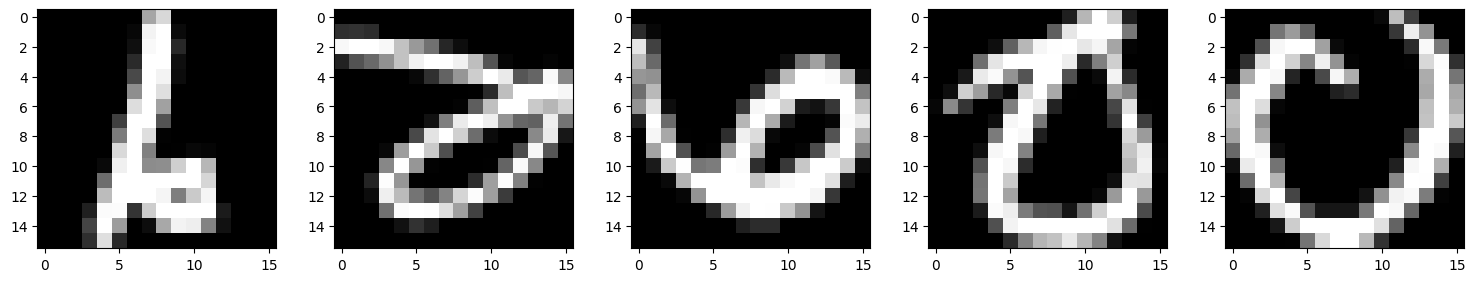

In [77]:
# Visualization function
def visualize_images(features, labels, predicted_labels, sample_indices):
    """
    Display images with their true and predicted labels.

    Inputs:
    - features (ndarray): Feature data for images.
    - labels (ndarray): True labels for images.
    - predicted_labels (ndarray): Predicted labels for images.
    - sample_indices (list): Indices of images to visualize.

    Output:
    - None
    """
    plt.figure(figsize=(15, 15))  # Set up figure size for visualization
    for i, idx in enumerate(sample_indices):
        print(f"True Label: {labels[idx]}, Predicted Label: {predicted_labels[idx]}")  # Display labels
        plt.subplot(1, len(sample_indices), i + 1)  # Create subplot for each sample
        image = np.reshape(features[idx], (16, 16))  # Reshape feature into 16x16 image
        plt.imshow(image, cmap="gray")  # Display image in grayscale
    plt.tight_layout()
    plt.show()

# Hardest-to-predict sample identification
error_counts = np.zeros(len(X))  # Array to count prediction errors for each sample
final_predictions = np.full(len(X), -1)  # Store final predictions for all samples

# Iterate through all runs to identify hardest-to-predict samples
for run_idx, optimal_degree in enumerate(best_degrees):
    # Split dataset into training and testing sets
    train_X, test_X, train_y, test_y = train_test_split(X, y, random_ratio=0.8, seed=run_idx)
    
    # Train model with the optimal degree for this run
    model = MultiClassPerceptronOVA(
        train_X, train_y, test_X, test_y, 
        kernel_param="p", kernel_param=optimal_degree, epochs=5
    )
    model.train()
    predicted_labels = model.predict(test_X, training_phase=False)  # Predict on test data

    # Update error counts for misclassified samples
    for test_sample_idx, (true_label, predicted_label) in enumerate(zip(test_y, predicted_labels)):
        if true_label != predicted_label:
            # Find the original index of the test sample
            original_index = np.where((X == test_X[test_sample_idx]).all(axis=1))[0][0]
            error_counts[original_index] += 1  # Increment error count
            final_predictions[original_index] = predicted_label  # Store the predicted label

# Identify the 5 samples with the highest error counts
hardest_samples = np.argsort(error_counts)[::-1][:5]

# Visualize the hardest-to-predict samples
visualize_images(X, y, final_predictions, hardest_samples)
